In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np

from RAiDER.models import HRES

In [2]:
# load sample data
ds1 = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/tests/data/test_data.nc')

## RAIDER calculation

In [225]:
hres_model = HRES()

# Extract temperature and specific humidity at the first time step
hres_model._t = ds1.t.isel(time=0).values
hres_model._q = ds1.q.isel(time=0).values

# Extract longitude and latitude values
longitude = ds1.longitude.values
latitude = ds1.latitude.values

# Use geopotential heights and log of surface pressure
# to get pressure, geopotential, and geopotential height
_, pres, hgt = hres_model._calculategeoh(
        ds1.z.isel(time=0, level=0).values,
        ds1.lnsp.isel(time=0, level=0).values
)
hres_model._p = pres

In [226]:
# Create latitude and longitude grid
hres_model._lons, hres_model._lats = np.meshgrid(longitude, latitude)

# Get altitudes
hres_model._get_heights(hres_model._lats, hgt.transpose(1, 2, 0))
h = hres_model._zs.copy()

# Re-structure arrays from (heights, lats, lons) to (lons, lats, heights)
hres_model._p = np.flip(hres_model._p.transpose(1, 2, 0), axis=2)
hres_model._t = np.flip(hres_model._t.transpose(1, 2, 0), axis=2)
hres_model._q = np.flip(hres_model._q.transpose(1, 2, 0), axis=2)
hres_model._zs = np.flip(h, axis=2)
hres_model._xs, hres_model._ys = hres_model._lons.copy(), hres_model._lats.copy()
hres_model._t.shape, hres_model._p.shape, hres_model._q.shape 
 

((213, 284, 137), (213, 284, 137), (213, 284, 137))

In [227]:
# Perform RAiDER computations
hres_model._find_e() 
hres_model._t.shape, hres_model._p.shape, hres_model._e.shape

((213, 284, 137), (213, 284, 137), (213, 284, 137))

In [228]:
# Perform RAiDER computations
h = hres_model._zs.copy()
hres_model._uniform_in_z(_zlevels=None)

hres_model._checkForNans()
hres_model._t.shape, hres_model._p.shape, hres_model._e.shape 

((213, 284, 145), (213, 284, 145), (213, 284, 145))

In [720]:
hres_model._get_wet_refractivity()
hres_model._get_hydro_refractivity()
hres_model._adjust_grid(hres_model.get_latlon_bounds())

# Compute zenith delays at the weather model grid nodes
hres_model._getZTD()

# Step-by-step

## Calculate surface pressure, geopotential_height

In [7]:
from RAiDER.models.model_levels import (
    A_137_HRES,
    B_137_HRES,
    LEVELS_25_HEIGHTS,
    LEVELS_137_HEIGHTS,
)
from RAiDER.utilFcns import calcgeoh

In [8]:
## XARRAY 
def get_surface_pressure(lnsp : xr.DataArray):
    isel = {}
    #Strip time and level dims 
    for i in ['time', 'level']:
        isel[i] = 0 if i in lnsp.dims else None

    lnsp = lnsp.isel(isel)
    lnsp = lnsp.expand_dims(level=range(138))
    lnsp = lnsp.astype(np.float32)

    # Get expanded a and b HRES values
    A_expanded = np.atleast_1d(A_137_HRES)[:, np.newaxis, np.newaxis]
    B_expanded = np.atleast_1d(B_137_HRES)[:, np.newaxis, np.newaxis]

    return  np.float32(A_expanded) + np.float32(B_expanded) * np.exp(lnsp)

R_d = 287.06  # in our original code this was 287.053
def get_geopotential(t : xr.DataArray, 
                     q : xr.DataArray, 
                     z : xr.DataArray, 
                     lnsp : xr.DataArray):
    # Get surface pressure
    Phd = get_surface_pressure(lnsp)

    # Get log and alpha at half levels
    Phd[0] = 1e-10
    dlogP = np.log(Phd).diff(dim="level", label='lower')
    dlogP[0] = np.log(Phd.isel(level=1) / 0.1)
    
    alpha = 1 - (Phd[:-1] / (Phd.diff(dim="level", label='lower'))) * dlogP
    alpha[0] *= np.float32(np.log(2))

    # Reverse
    dlogP = dlogP.isel(level=slice(None, None, -1))
    alpha = alpha.isel(level=slice(None, None, -1))
    dlogP = dlogP.assign_coords(level=range(1,138))
    alpha = alpha.assign_coords(level=range(1,138))

    # compute moist temperature amd reverse
    moist = t * (1 + 0.609133 * q)
    TRd = moist.isel(level=slice(None, None, -1)) * R_d
    TRd = TRd.assign_coords(level=range(1,138))
    z1 = TRd * alpha.astype(np.float64) + z.isel(level=0).expand_dims(level=range(1, 138))
    z2 = TRd * dlogP

    # Get Geopotential, in reverse
    return z1 + z2.astype(np.float64).cumsum('level').shift(level=1, fill_value=0)

In [916]:
%%time
surface_pressure =  get_surface_pressure(ds1.lnsp)[:-1]

CPU times: user 56.3 ms, sys: 9.3 ms, total: 65.6 ms
Wall time: 56.4 ms


In [917]:
%%time
pres = calcgeoh(ds1.lnsp.isel(time=0, level=0).values,
         ds1.t.isel(time=0).values,
         ds1.q.isel(time=0).values,
         ds1.z.isel(time=0, level=0).values,
         A_137_HRES, B_137_HRES, R_d, 137)[1]

CPU times: user 75.1 ms, sys: 10 ms, total: 85.1 ms
Wall time: 82.1 ms


In [9]:
## Get surface pressure
surface_pressure =  get_surface_pressure(ds1.lnsp)[:-1]

# Raider
pres = calcgeoh(ds1.lnsp.isel(time=0, level=0).values,
         ds1.t.isel(time=0).values,
         ds1.q.isel(time=0).values,
         ds1.z.isel(time=0, level=0).values,
         A_137_HRES, B_137_HRES, R_d, 137)[1]

array(0., dtype=float32)

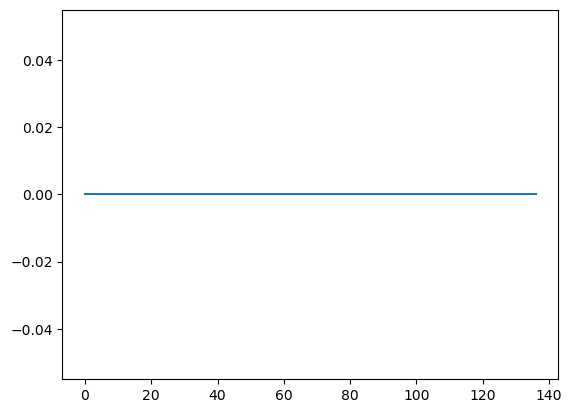

In [45]:
plt.plot(surface_pressure[:,0,0]-pres[:,0,0])
np.amax(surface_pressure[:,0,0]-pres[:,0,0]).values

In [918]:
%%time
geopotential = get_geopotential(ds1.t, ds1.q,
                                ds1.z, ds1.lnsp)

CPU times: user 267 ms, sys: 197 ms, total: 464 ms
Wall time: 438 ms


In [919]:
%%time
gp = calcgeoh(ds1.lnsp.isel(time=0, level=0).values,
         ds1.t.isel(time=0).values,
         ds1.q.isel(time=0).values,
         ds1.z.isel(time=0, level=0).values,
         A_137_HRES, B_137_HRES, R_d, 137)[0]

CPU times: user 72.2 ms, sys: 976 μs, total: 73.1 ms
Wall time: 70.6 ms


In [11]:
# Geopotential

geopotential = get_geopotential(ds1.t, ds1.q,
                                ds1.z, ds1.lnsp)

# Raider
gp = calcgeoh(ds1.lnsp.isel(time=0, level=0).values,
         ds1.t.isel(time=0).values,
         ds1.q.isel(time=0).values,
         ds1.z.isel(time=0, level=0).values,
         A_137_HRES, B_137_HRES, R_d, 137)[0]

In [12]:
plt.plot(geopotential[0,::-1,0,0].astype(np.float32) - gp[:,0,0])

In [13]:
# Geoheights
# Geopotential
g0 = np.float32(9.80665)
geoheight = get_geopotential(ds1.t, ds1.q,
                                ds1.z, ds1.lnsp).astype(np.float32) / g0

# Raider
hgt = calcgeoh(ds1.lnsp.isel(time=0, level=0).values,
         ds1.t.isel(time=0).values,
         ds1.q.isel(time=0).values,
         ds1.z.isel(time=0, level=0).values,
         A_137_HRES, B_137_HRES, R_d, 137)[2]

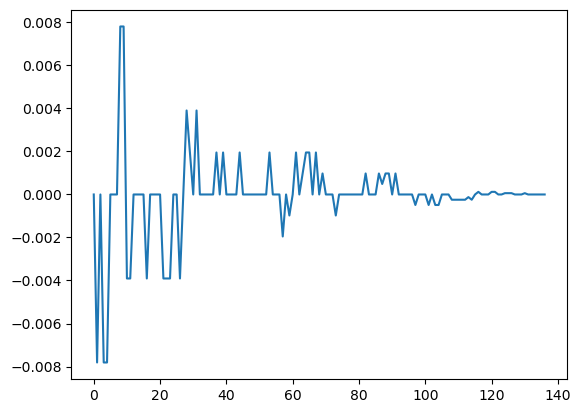

In [46]:
plt.plot(geoheight[0,::-1,0,0] - hgt[:,0,0])

plot above is precision resiudal, probably due to different stage usage of float64 and float32 

## Get ellipsoidal heightd

In [15]:
from RAiDER.constants import (
    _g1 as G1,
)

from RAiDER.constants import (
    R_EARTH_MAX_WGS84 as Rmax,
)
from RAiDER.constants import (
    R_EARTH_MIN_WGS84 as Rmin,)

In [16]:
def get_Re(lats: np.array) -> np.array:
    """
    Returns earth radius as a function of latitude for WGS84.

    Args: lats
        ndarray of geodetic latitudes in degrees

    Returns:
        ndarray of earth radius at each latitude

    Example:
    >>> import numpy as np
    >>> from RAiDER.utilFcns import get_Re
    >>> output = get_Re(np.array([0, 30, 45, 60, 90]))
    >>> output
     array([6378137., 6372770.5219805, 6367417.56705189, 6362078.07851428, 6356752.])
    >>> assert output[0] == 6378137 # (Rmax)
    >>> assert output[-1] == 6356752 # (Rmin)
    """
    return np.sqrt(1 / (((np.cos(np.radians(lats)) ** 2) / Rmax**2) + ((np.sin(np.radians(lats)) ** 2) / Rmin**2)))

def _get_g_ll(lats: np.array) ->  np.array:
    """Compute the variation in gravity constant with latitude."""
    return G1 * (1 - 0.002637 * np.cos(np.radians(2 * lats)) + 0.0000059 * (np.cos(np.radians(2 * lats))) ** 2)

In [32]:
g_ll = _get_g_ll(ds1.latitude)  # gravity function of latitude
Re = get_Re(ds1.latitude)  # Earth radius function of latitude

# Calculate Geometric Height, h
h1 = (geoheight * Re) / (g_ll / g0 * Re - geoheight)

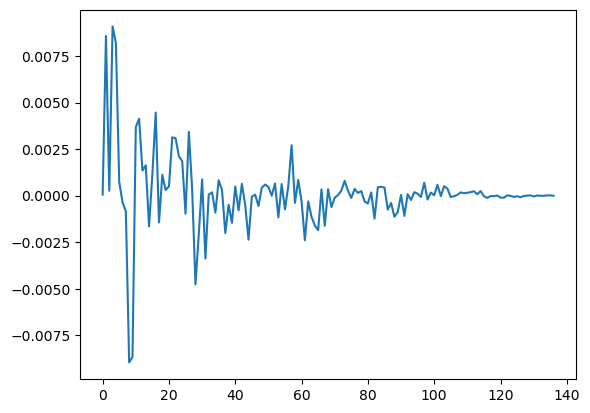

In [44]:
plt.plot(h[0,0,:] - h1[0,::-1,0,0].astype(np.float32))

# Partial pressure

In [56]:
R_v = 461.524
def get_svp_xr(t : xr.DataArray):
    t1 = 273.15  # O Celsius
    t2 = 250.15  # -23 Celsius

    tref = t - t1
    wgt = (t - t2) / (t1 - t2)

    tref = t - t1
    wgt = (t - t2) / (t1 - t2)
    svpw = 6.1121 * np.exp((17.502 * tref) / (240.97 + tref))
    svpi = 6.1121 * np.exp((22.587 * tref) / (273.86 + tref))

    svp = svpi + (svpw - svpi) * wgt**2

    svp = svpi + (svpw - svpi) * wgt**2
    ix_bound1 = t > t1
    svp = svp.where(~ix_bound1, svpw)

    ix_bound2 = t < t2
    svp = svp.where(~ix_bound2, svpi)

    return svp * 100

def get_e_from_q(t : xr.DataArray,
                 q : xr.DataArray,
                 p : xr.DataArray):
    # Get standard vapor pressure
    svp = get_svp_xr(t)

    w = q / (1 - q)
    return w * R_v * (p - svp) / R_d

In [66]:
from RAiDER.models.weatherModel import find_svp
svp = get_svp_xr(ds1.t)

In [69]:
svp1 = find_svp(ds1.t.isel(time=0).values)

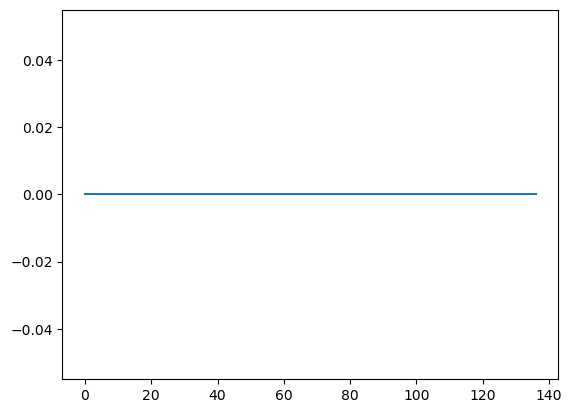

In [76]:
plt.plot(svp1[:,0,0] - svp[0,:,0,0])

In [62]:
surface_pressure = surface_pressure.assign_coords(level=range(1,138))

In [795]:
e = get_e_from_q(ds1.t, ds1.q, surface_pressure)

In [796]:
e

<xarray.DataArray (time: 1, level: 137, latitude: 213, longitude: 284)> Size: 33MB
array([[[[-5.5691606e-07, -5.5928740e-07, -5.6061759e-07, ...,
          -5.9443664e-07, -5.9756559e-07, -6.0070988e-07],
         [-5.5956951e-07, -5.6061759e-07, -5.6195103e-07, ...,
          -5.9271912e-07, -5.9583971e-07, -5.9897548e-07],
         [-5.6061759e-07, -5.6195103e-07, -5.6300337e-07, ...,
          -5.9100620e-07, -5.9411838e-07, -5.9865482e-07],
         ...,
         [-6.8505148e-07, -6.8186097e-07, -6.7868393e-07, ...,
          -1.2017482e-06, -1.2044588e-06, -1.2098952e-06],
         [-6.8075121e-07, -6.7757935e-07, -6.7599905e-07, ...,
          -1.1982394e-06, -1.2036504e-06, -1.2090848e-06],
         [-6.7647483e-07, -6.7489708e-07, -6.7211687e-07, ...,
          -1.1947369e-06, -1.2007642e-06, -1.2061867e-06]],

        [[ 5.8228006e-06,  5.8177134e-06,  5.8101145e-06, ...,
           4.9266896e-06,  4.9193382e-06,  4.9144260e-06],
         [ 5.8228006e-06,  5.8151322e-06,  5.8100381e-06, ...,
           4.9316095e-06,  4.9242531e-06,  4.9168807e-06],
         [ 5.8177134e-06,  5.8151322e-06,  5.8099536e-06, ...,
           4.9365294e-06,  4.9291680e-06,  4.9217911e-06],
...
           1.5971272e+03,  1.6332402e+03,  1.6735212e+03],
         [ 1.8628560e+03,  1.7418979e+03,  1.6108605e+03, ...,
           1.5866974e+03,  1.6241815e+03,  1.6568392e+03],
         [ 1.8384622e+03,  1.7767520e+03,  1.6595988e+03, ...,
           1.6211586e+03,  1.6569902e+03,  1.6631316e+03]],

        [[ 6.3479742e+02,  6.2077094e+02,  6.2586987e+02, ...,
           2.0255222e+02,  1.9598784e+02,  1.8942633e+02],
         [ 5.4748889e+02,  5.6017334e+02,  5.8215088e+02, ...,
           1.8488097e+02,  1.8602524e+02,  1.8719527e+02],
         [ 5.6090155e+02,  5.8425629e+02,  6.0538647e+02, ...,
           2.1113765e+02,  2.0682179e+02,  2.1124620e+02],
         ...,
         [ 1.8521622e+03,  1.7017064e+03,  1.5583418e+03, ...,
           1.6779818e+03,  1.7080651e+03,  1.7423948e+03],
         [ 1.8982451e+03,  1.7832422e+03,  1.6566602e+03, ...,
           1.6600326e+03,  1.6902178e+03,  1.7217026e+03],
         [ 1.8712620e+03,  1.8131077e+03,  1.6980883e+03, ...,
           1.6807721e+03,  1.7117314e+03,  1.7227781e+03]]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB 65.04 65.11 65.18 ... 84.8 84.87 84.94
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * level      (level) int32 548B 1 2 3 4 5 6 7 ... 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 8B 2024-02-15T12:00:00

In [562]:
plt.plot(e[0,:,0,0] - hres_model._e[0,0,::-1])

ValueError: operands could not be broadcast together with shapes (1,284) (145,) 

# uniform in z

In [ ]:
def _uniform_in_z(self, _zlevels: Union[np.ndarray, list]=None) -> None:
        """Interpolate all variables to a regular grid in z."""
        nx, ny = self._p.shape[:2]

        # new regular z-spacing
        if _zlevels is None:
            try:
                _zlevels = self._zlevels
            except:
                _zlevels = np.nanmean(self._zs, axis=(0, 1))

        new_zs = np.tile(_zlevels, (nx, ny, 1))

        # re-assign values to the uniform z
        self._t = interpolate_along_axis(self._zs, self._t, new_zs, axis=2, fill_value=np.nan).astype(np.float32)
        self._p = interpolate_along_axis(self._zs, self._p, new_zs, axis=2, fill_value=np.nan).astype(np.float32)
        self._e = interpolate_along_axis(self._zs, self._e, new_zs, axis=2, fill_value=np.nan).astype(np.float32)

        self._zs = _zlevels
        self._xs = np.unique(self._xs)
        self._ys = np.unique(self._ys)

In [91]:
hres_model._zlevels.shape

(145,)

In [ ]:
h1.isel(level=slice(None, None, -1)).assign_coords(level=range(1,38))

In [579]:
# Get
ds2 = ds1.copy()
ds2['p'] = surface_pressure.expand_dims(dim="time")
ds2['e'] = e
ds2['hgt'] = h1.isel(level=slice(None, None, -1))
ds2 = ds2.drop_vars(['z', 'lnsp', 'q'])

In [580]:
ds2

<xarray.Dataset> Size: 166MB
Dimensions:    (longitude: 284, latitude: 213, level: 137, time: 1)
Coordinates:
  * longitude  (longitude) float32 1kB 65.04 65.11 65.18 ... 84.8 84.87 84.94
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * level      (level) int32 548B 1 2 3 4 5 6 7 ... 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 8B 2024-02-15T12:00:00
Data variables:
    t          (time, level, latitude, longitude) float32 33MB 200.9 ... 295.3
    p          (time, level, latitude, longitude) float32 33MB 0.0 ... 1.005e+05
    e          (time, level, latitude, longitude) float32 33MB -5.569e-07 ......
    hgt        (time, level, latitude, longitude) float64 66MB 354.2 ... 7.87...
Attributes:
    Conventions:  CF-1.6
    history:      2025-03-04 22:54:08 GMT by grib_to_netcdf-2.28.1: grib_to_n...

In [149]:
ds2.hgt[0,:,0,0]

<xarray.DataArray 'hgt' (level: 137)> Size: 1kB
array([77985.88286775, 72366.21151571, 69799.96119921, 67459.14172359,
       65313.93380523, 63265.26635172, 61244.35511538, 59242.78431444,
       57268.84275074, 55335.70632339, 53454.85126955, 51635.4610944 ,
       49879.79821889, 48186.27506722, 46557.48271732, 44998.0519338 ,
       43514.3676863 , 42119.63527919, 40794.2237748 , 39523.37139502,
       38316.64893689, 37160.66324102, 36055.92881485, 35020.52551062,
       34057.75575459, 33156.69824932, 32303.93111663, 31494.54330176,
       30728.03043182, 29998.95888998, 29300.87000905, 28630.1392399 ,
       27985.33794957, 27365.24822148, 26768.40143156, 26194.26840161,
       25641.83819501, 25108.99019071, 24594.24950538, 24095.48293192,
       23611.08447891, 23141.35272666, 22686.36782058, 22244.42526908,
       21813.31210467, 21391.58588143, 20979.98052619, 20579.26311293,
       20189.22503598, 19809.50059467, 19437.4594514 , 19071.99609129,
       18713.38541697, 18362.67072386, 18019.02796577, 17682.04418368,
       17350.40872906, 17022.10035018, 16695.54062765, 16371.13266947,
       16048.14031319, 15727.08648298, 15408.2985184 , 15091.30453082,
       14775.70055289, 14461.34287749, 14148.16244253, 13836.68979548,
       13527.69175201, 13222.37732167, 12921.72059534, 12626.0449516 ,
       12333.76003346, 12044.44024368, 11757.49245325, 11472.40710232,
       11188.51891782, 10905.50502857, 10623.43676887, 10342.37956711,
       10061.10895068,  9779.13200696,  9496.18041275,  9212.80708882,
        8928.72996764,  8644.38129519,  8359.3918277 ,  8073.30380531,
        7786.77718805,  7499.47323771,  7212.08353636,  6924.31141698,
        6636.65730608,  6348.99537239,  6061.02362407,  5773.64512267,
        5488.64641217,  5207.71749251,  4931.76981235,  4661.95865902,
        4398.67922299,  4143.21933127,  3896.29074476,  3658.12208961,
        3429.11512035,  3209.83513067,  2999.86276015,  2800.54716787,
        2611.18938329,  2432.24793517,  2263.7477132 ,  2103.9266991 ,
        1954.60631431,  1814.67976276,  1683.38916146,  1560.53817931,
        1447.02868871,  1341.18259125,  1242.1772159 ,  1152.16419243,
        1067.20277854,   989.725598  ,   918.84834168,   852.42320603,
         791.61589772,   735.63284301,   684.81057981,   636.5519829 ,
         593.48254432,   554.10646123,   515.88850391,   484.71585966,
         453.48546868,   423.92720584,   400.69495442,   374.99266041,
         354.16530636])
Coordinates:
    longitude  float32 4B 65.04
    latitude   float32 4B 39.96
  * level      (level) int64 1kB 1 2 3 4 5 6 7 8 ... 131 132 133 134 135 136 137
    time       datetime64[ns] 8B 2024-02-15T12:00:00

In [448]:
def interpolate(t, hgt, new_heights, method='linear', fill_value=0):
    data = xr.DataArray(t, dims=['hgt'],
                    coords={'hgt':hgt.data})

    # Interpolate 
    interp = data.interp(hgt=new_heights, method=method)
    
    # Fill NaN values with the last non-NaN value or the specified fill_value
    interp_filled = interp.sortby('hgt').interpolate_na(dim='hgt',  
                    fill_value=(interp[~interp.isnull()][-1], 
                                fill_value))
    interp_filled = interp_filled.assign_coords({'latitude':t.latitude,
                    'longitude':t.longitude})
    return interp_filled.expand_dims(['latitude', 'longitude'])


In [450]:
def interpolate(t, hgt, new_heights, method='linear', fill_value=0):
    data = xr.DataArray(t, dims=['hgt'],
                    coords={'hgt':hgt.data})

    # Interpolate 
    interp = data.interp(hgt=new_heights, method=method)
    
    # Fill NaN values with the last non-NaN value or the specified fill_value
    interp_filled = interp.sortby('hgt').interpolate_na(dim='hgt',  
                    fill_value=(interp[~interp.isnull()][-1], 
                                fill_value))
    interp_filled = interp_filled.assign_coords({'latitude':t.latitude,
                    'longitude':t.longitude})
    return interp_filled.expand_dims(['latitude', 'longitude'])

# Loop through each latitude and longitude slice and apply the interpolation
def apply_interpolation_on_lat_lon(ds, new_heights, method='cubic', fill_value=0):
    # Create an empty list to store the results for each lat-lon slice
    interpolated_list = []

    # Loop through each lat-lon slice
    for lat_idx in range(ds.latitude.size):
        for lon_idx in range(ds.longitude.size):
            # Extract the slice for the current lat-lon point
            t_slice = ds.t.isel(time=0, latitude=lat_idx, longitude=lon_idx)
            # Extract temperature data for this lat-lon slice
            hgt_slice = ds.hgt.isel(time=0, latitude=lat_idx, longitude=lon_idx)
            
            # Apply the interpolation function to this slice
            interpolated_slice = interpolate(t_slice, hgt_slice, new_heights,
                                             method=method, fill_value=fill_value)
            
            # Store the result in the list
            interpolated_list.append(interpolated_slice)

    interpolated_xr = xr.combine_by_coords(interpolated_list)
    return interpolated_xr 

In [449]:
%%time
interpolated_list = []

# Loop through each lat-lon slice
for lat_idx in range(ds2.latitude.size):
    for lon_idx in range(ds2.longitude.size):
        # Extract the slice for the current lat-lon point
        t_slice = ds2.t.isel(time=0, latitude=lat_idx, longitude=lon_idx)
        # Extract temperature data for this lat-lon slice
        hgt_slice = ds2.hgt.isel(time=0, latitude=lat_idx, longitude=lon_idx)
        
        # Apply the interpolation function to this slice
        interpolated_slice = interpolate(t_slice, hgt_slice, LEVELS_137_HEIGHTS)
        
        # Store the result in the list
        interpolated_list.append(interpolated_slice)

interpolated_xr = xr.combine_by_coords(interpolated_list)

CPU times: user 4min 22s, sys: 1.96 s, total: 4min 24s
Wall time: 4min 24s


In [506]:
interpolated_xr.t[0,0,:]

<xarray.DataArray 't' (hgt: 145)> Size: 1kB
array([296.56456316, 296.56456316, 296.56456316, 296.56456316,
       296.56456316, 296.56456316, 296.56456316, 296.56456316,
       296.46373826, 296.25762003, 296.04845371, 295.80045235,
       295.57793845, 295.47722652, 295.62897476, 296.0081908 ,
       296.01760066, 295.76264655, 295.68758643, 295.4047214 ,
       295.1423332 , 294.82181249, 294.47303326, 294.08710668,
       293.67796801, 293.13211724, 292.45785941, 291.76744953,
       291.08700901, 290.32163651, 289.44636254, 288.48974485,
       287.3277944 , 285.99848538, 284.81053979, 283.79160602,
       282.71709888, 281.69478095, 280.99883772, 280.82426488,
       280.60915799, 279.53683946, 277.80206534, 276.06237936,
       274.50520051, 273.06897534, 271.71888723, 270.4797202 ,
       269.32415631, 268.04455175, 266.39504137, 264.32514357,
       262.22319762, 260.50150309, 258.73363988, 256.82872589,
       255.0408604 , 253.26767311, 251.25243405, 248.96574477,
       246.57126081, 244.16335442, 241.79929027, 239.47579557,
       237.18053451, 234.99321619, 232.96019796, 231.02172377,
       229.08924721, 227.04938452, 224.96980539, 223.08306924,
       221.52466728, 220.08830672, 218.51104959, 216.78470057,
       215.14368065, 213.71538443, 212.30276593, 210.71985888,
       208.98579235, 207.16970063, 205.21558032, 203.1931532 ,
       201.17812712, 199.34313735, 198.12878303, 197.2286867 ,
       196.71674013, 196.40187414, 196.28142855, 196.38654609,
       196.60791707, 197.84635629, 200.06102954, 201.77117705,
       203.46301505, 205.13078325, 206.24280133, 206.77023518,
       207.40259452, 208.64014926, 210.48724816, 211.04121263,
       210.71253713, 211.3016288 , 212.99914003, 214.44199187,
       215.90697064, 217.85209853, 219.33082536, 219.68038642,
       219.09978292, 218.55131939, 218.26569548, 218.77370575,
       220.41000025, 222.91838488, 227.21079038, 231.53373945,
       234.99143465, 239.53082101, 245.0226478 , 251.79632736,
       256.88180086, 258.63796043, 258.8763137 , 259.37122158,
       260.54358642, 262.16632599, 265.91010611, 265.94503794,
       264.25383934, 260.33398479, 254.76798725, 248.20115495,
       241.19619135, 232.61575731, 222.27202483, 212.00232039,
       206.84773965, 205.73224236, 204.73238563, 204.01391927,
         0.        ])
Coordinates:
  * hgt        (hgt) float64 1kB -500.0 -300.0 -200.0 ... 7.458e+04 8.03e+04
    longitude  float32 4B 65.04
    latitude   float32 4B 25.06
    time       datetime64[ns] 8B 2024-02-15T12:00:00
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [516]:
from RAiDER.interpolate import interpolate_along_axis
from RAiDER.interpolator import fillna3D

In [590]:
ds = ds2.copy()
ds = ds.transpose('time', 'latitude', 'longitude', 'level')

In [638]:
new_shape = (ds.sizes['latitude'], ds.sizes['longitude'], 1) 
new_zs = np.tile(LEVELS_137_HEIGHTS, new_shape)


In [644]:
isel_slice = dict(time=0)

In [649]:
interp = interpolate_along_axis(ds.hgt.isel(isel_slice),
                                ds.t.isel(isel_slice)[:,:,::-1],
                                new_zs,  axis=2, 
                                fill_value=np.nan)

interp_fill = fillna3D(interp[:,:,::-1])

In [646]:
ds.t.isel(isel_slice).values.shape

(213, 284, 137)

In [650]:
interp_fill[0,0,:]

array([294.41356163, 294.41356163, 294.41356163, 294.41356163,
       294.41356163, 294.41356163, 294.41356163, 294.41356163,
       294.41356163, 294.41356163, 294.41356163, 294.41356163,
       294.41356163, 294.41356163, 294.41356163, 294.41356163,
       294.41356163, 294.41356163, 294.41356163, 294.41356163,
       294.64462655, 294.33009905, 293.77180724, 293.07282167,
       292.34917487, 291.51281283, 290.65975453, 289.69880483,
       288.94793539, 288.48783589, 287.8384232 , 286.8012726 ,
       285.50204003, 284.05441594, 282.49291327, 280.88432188,
       279.14824126, 277.36732556, 275.74846678, 274.31960464,
       272.79295695, 270.97978894, 268.92816   , 266.96395288,
       265.35063909, 263.79210957, 262.1327212 , 260.36812105,
       258.53226954, 256.98746932, 256.31392037, 254.45343131,
       252.23893095, 250.22811942, 248.12692931, 245.94471531,
       243.67444629, 241.26492231, 238.67663948, 235.93792714,
       233.2163798 , 230.64302495, 228.30671773, 225.83

In [689]:
def uniform_heights(ds : xr.DataArray, hgt: xr.DataArray, 
                    new_heights : list, fill_value:float=0):
    # new heights
    ds= ds.copy()
    new_shape = (ds.sizes['latitude'], ds.sizes['longitude'], 1) 
    new_zs = np.tile(new_heights, new_shape)

    # Interpolate
    ds = ds.transpose('time', 'latitude', 'longitude', 'level')
    hgt = hgt.transpose('time', 'latitude', 'longitude', 'level')
    isel_slice = dict(time=0)
    interp = interpolate_along_axis(hgt.isel(isel_slice),
                                    ds.isel(isel_slice)[:,:,::-1],
                                    new_zs,  axis=2, 
                                    fill_value=np.nan)
    # fill nans
    inter_filled = fillna3D(interp, fill_value=fill_value)

    return xr.DataArray(inter_filled.transpose(2,0,1),
                        dims=['height', 'latitude', 'longitude'],
                        coords={'height':new_heights,
                              'latitude':ds.latitude,
                              'longitude':ds.longitude})



In [709]:
t1 = uniform_heights(ds2.t, ds2.hgt, np.flipud(LEVELS_137_HEIGHTS), 1e16)
e1 = uniform_heights(ds2.e, ds2.hgt, np.flipud(LEVELS_137_HEIGHTS), 0)
p1 = uniform_heights(ds2.p, ds2.hgt, np.flipud(LEVELS_137_HEIGHTS), 0) 
ds = xr.Dataset(data_vars=dict(t=t1, e=e1, p=p1)) 

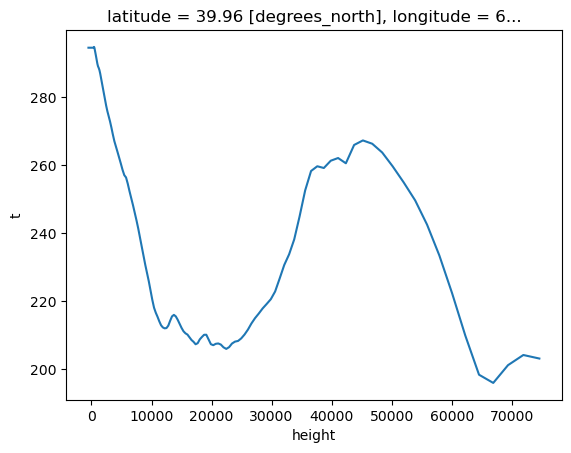

In [713]:
ds.t[:-1,0,0].plot()


In [ ]:

new_zs = np.tile(LEVELS_137_HEIGHTS, (*ds2.t[0].shape[1:],1))
ds3 = ds2.transpose('time', 'latitude', 'longitude', 'level')
dd = interpolate_along_axis(ds3.hgt[0].values[:,:,::-1],
                       ds3.t[0].values[:,:,::-1],
                       new_zs,  axis=2, fill_value=np.nan)
dd = fillna3D(dd[:,:,::-1])

interp = xr.DataArray(dd.transpose(2,0,1), dims=['height', 'latitude', 'longitude'],
                      coords={'height':np.flipud(LEVELS_137_HEIGHTS),
                              'latitude':ds2.latitude,
                              'longitude':ds2.longitude})
interp =interp.assign_attrs(ds2.t.attrs)

In [528]:

interp

<xarray.DataArray (height: 145, latitude: 213, longitude: 284)> Size: 70MB
array([[[294.41356163, 294.28964967, 293.97972067, ..., 279.36091201,
         279.48239908, 279.54511068],
        [295.43782052, 295.13700516, 294.83957259, ..., 279.13223234,
         279.14094391, 279.16328641],
        [296.03340732, 295.81793888, 295.46513993, ..., 278.15893522,
         278.20881545, 278.41057184],
        ...,
        [295.85366049, 295.87483279, 296.05311406, ..., 295.52396516,
         295.01674732, 295.29477875],
        [296.37987979, 296.50907772, 296.62695257, ..., 295.60349079,
         295.60012446, 295.65726214],
        [296.56456316, 296.65812885, 296.84586877, ..., 295.60600735,
         295.5457196 , 295.53633165]],

       [[294.41356163, 294.28964967, 293.97972067, ..., 279.36091201,
         279.48239908, 279.54511068],
        [295.43782052, 295.13700516, 294.83957259, ..., 279.13223234,
         279.14094391, 279.16328641],
        [296.03340732, 295.81793888, 295.46513993, ..., 278.15893522,
         278.20881545, 278.41057184],
...
        [204.03795948, 204.01882428, 204.01068881, ..., 207.10691308,
         207.13425008, 207.15415237],
        [204.02019405, 204.0124931 , 203.99651793, ..., 207.12224474,
         207.14194371, 207.173913  ],
        [204.01391927, 203.9988451 , 203.99009247, ..., 207.12628142,
         207.15743432, 207.18918237]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * height     (height) float64 1kB -500.0 -300.0 -200.0 ... 7.458e+04 8.03e+04
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * longitude  (longitude) float32 1kB 65.04 65.11 65.18 ... 84.8 84.87 84.94
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [692]:
interpolated_xr.t[0,0,:]

<xarray.DataArray 't' (hgt: 145)> Size: 1kB
array([296.56456316, 296.56456316, 296.56456316, 296.56456316,
       296.56456316, 296.56456316, 296.56456316, 296.56456316,
       296.46373826, 296.25762003, 296.04845371, 295.80045235,
       295.57793845, 295.47722652, 295.62897476, 296.0081908 ,
       296.01760066, 295.76264655, 295.68758643, 295.4047214 ,
       295.1423332 , 294.82181249, 294.47303326, 294.08710668,
       293.67796801, 293.13211724, 292.45785941, 291.76744953,
       291.08700901, 290.32163651, 289.44636254, 288.48974485,
       287.3277944 , 285.99848538, 284.81053979, 283.79160602,
       282.71709888, 281.69478095, 280.99883772, 280.82426488,
       280.60915799, 279.53683946, 277.80206534, 276.06237936,
       274.50520051, 273.06897534, 271.71888723, 270.4797202 ,
       269.32415631, 268.04455175, 266.39504137, 264.32514357,
       262.22319762, 260.50150309, 258.73363988, 256.82872589,
       255.0408604 , 253.26767311, 251.25243405, 248.96574477,
       246.57126081, 244.16335442, 241.79929027, 239.47579557,
       237.18053451, 234.99321619, 232.96019796, 231.02172377,
       229.08924721, 227.04938452, 224.96980539, 223.08306924,
       221.52466728, 220.08830672, 218.51104959, 216.78470057,
       215.14368065, 213.71538443, 212.30276593, 210.71985888,
       208.98579235, 207.16970063, 205.21558032, 203.1931532 ,
       201.17812712, 199.34313735, 198.12878303, 197.2286867 ,
       196.71674013, 196.40187414, 196.28142855, 196.38654609,
       196.60791707, 197.84635629, 200.06102954, 201.77117705,
       203.46301505, 205.13078325, 206.24280133, 206.77023518,
       207.40259452, 208.64014926, 210.48724816, 211.04121263,
       210.71253713, 211.3016288 , 212.99914003, 214.44199187,
       215.90697064, 217.85209853, 219.33082536, 219.68038642,
       219.09978292, 218.55131939, 218.26569548, 218.77370575,
       220.41000025, 222.91838488, 227.21079038, 231.53373945,
       234.99143465, 239.53082101, 245.0226478 , 251.79632736,
       256.88180086, 258.63796043, 258.8763137 , 259.37122158,
       260.54358642, 262.16632599, 265.91010611, 265.94503794,
       264.25383934, 260.33398479, 254.76798725, 248.20115495,
       241.19619135, 232.61575731, 222.27202483, 212.00232039,
       206.84773965, 205.73224236, 204.73238563, 204.01391927,
         0.        ])
Coordinates:
  * hgt        (hgt) float64 1kB -500.0 -300.0 -200.0 ... 7.458e+04 8.03e+04
    longitude  float32 4B 65.04
    latitude   float32 4B 25.06
    time       datetime64[ns] 8B 2024-02-15T12:00:00
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [422]:
interpolated_ds = xr.apply_ufunc(
        interpolate,
        ds2.t,
        ds2.hgt,
        LEVELS_137_HEIGHTS,
        input_core_dims=[['level', 'latitude', 'longitude'],
                         ['level', 'latitude', 'longitude'],
                         []],  # Apply along the 'level' dimension
        output_core_dims=[['hgt', 'latitude', 'longitude']],  # Output dimension will be the 'hgt' dimension
        exclude_dims={"time"}
        vectorize=True,  # Enable vectorization to apply to each lat-lon slice
    )
    

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (213, 284) and arg 2 with shape (145,).

In [370]:
np.tile(LEVELS_137_HEIGHTS,
        (ds2.latitude.shape[0], ds2.longitude.shape[0], 1)).shape

(213, 284, 145)

In [369]:
new_heights = xr.DataArray(np.tile(LEVELS_137_HEIGHTS,
                            (ds2.latitude.shape[0], ds2.longitude.shape[0], 1)),
                    dims=['latitude', 'longitude', 'hgt'],
                    coords={
                            'latitude':ds2.latitude,
                            'longitude':ds2.longitude,
                            'hgt':range(1,146)})
new_heights

<xarray.DataArray (latitude: 213, longitude: 284, hgt: 145)> Size: 70MB
array([[[80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        ...,
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ]],

       [[80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
...
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ]],

       [[80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        ...,
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ],
        [80301.65, 74584.91, 71918.79, ...,  -200.  ,  -300.  ,
          -500.  ]]])
Coordinates:
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * longitude  (longitude) float32 1kB 65.04 65.11 65.18 ... 84.8 84.87 84.94
  * hgt        (hgt) int64 1kB 1 2 3 4 5 6 7 8 ... 139 140 141 142 143 144 145

In [368]:
interpolated_ds = xr.apply_ufunc(
    interpolate,  # Interpolation function
    ds2.t.isel(time=0),  # The temperature variable (time, level, latitude, longitude)
    ds2.hgt.isel(time=0),  # The height variable (time, level, latitude, longitude)
    new_heights,  # The new heights to interpolate to
    input_core_dims=[['level'], ['level'], ['hgt']],  # Apply interpolation along the 'level' dimension
    output_core_dims=[['hgt']],  # The output dimension is the new heights (hgt)
    #vectorize=True,  # Vectorize to apply to each slice independently
    #dask='allowed'  # Enable parallel processing with Dask if needed
)

(213, 284, 137)
(213, 284, 137)
(213, 284, 145)


ValueError: different number of dimensions on data and dims: 3 vs 1

In [ ]:
"""Fill in NaN-values."""
#self._p = fillna3D(self._p)
#self._t = fillna3D(self._t, fill_value=1e16)  # to avoid division by zero later on
#self._e = fillna3D(self._e)

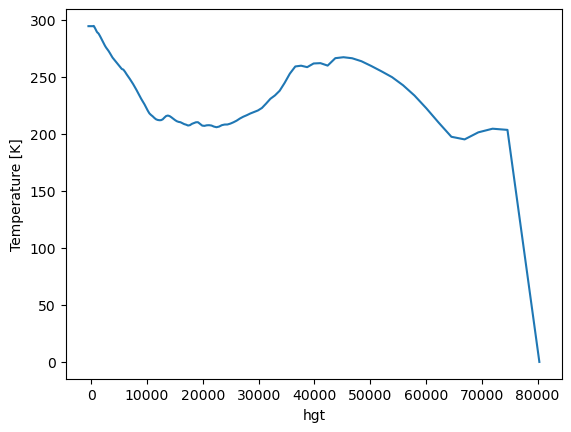

In [308]:
interpolate(ds2.t[0,:,0,0], ds2.hgt[0,:,0,0], LEVELS_137_HEIGHTS).plot()

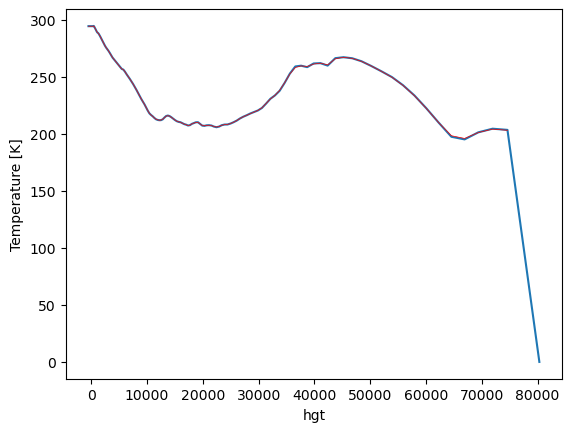

In [302]:
fig, ax = plt.subplots()
(interpolate(ds2.t[0,:,0,0], ds2.hgt[0,:,0,0], LEVELS_137_HEIGHTS)).plot(ax=ax)
ax.plot(hres_model._zs,
         np.ma.masked_where(hres_model._t[0,0,:]>1e14, hres_model._t[0,0,:]), color='red', lw=0.5)

In [185]:
ds3 = ds1.t[0,:, 0,0]
ds3.assign_coords(hgt = ds2.hgt[0,:,0,0])
ds3 = ds3.rename({'level':'hgt'})


In [196]:
data = xr.DataArray(ds1.t[0,:,0,0], dims=['hgt'],
                    coords={'hgt':ds2.hgt[0,:,0,0].data})

In [270]:
dd = data.interp(hgt=LEVELS_137_HEIGHTS,
            method='cubic', kwargs={"fill_value": np.nan})

In [274]:
dd

<xarray.DataArray 't' (hgt: 145)> Size: 1kB
array([         nan, 203.49563988, 204.52641421, 201.3453695 ,
       195.15179499, 197.45120272, 209.87462297, 222.40611265,
       233.59607575, 242.61299473, 249.7368908 , 254.88853726,
       259.57922804, 263.71045731, 266.31078028, 267.21861627,
       266.38357254, 259.86397926, 262.02037488, 261.73446061,
       258.51038737, 259.7863747 , 259.11914182, 252.79654775,
       244.67380346, 237.79716606, 233.69344511, 230.77721049,
       226.53562159, 222.70027721, 220.51367523, 219.16917099,
       217.86893571, 216.33350608, 215.03281623, 213.44798212,
       211.57935452, 210.17114264, 209.01237519, 208.22777039,
       208.17679949, 207.62648788, 206.39417268, 205.84004652,
       206.37416817, 207.30979035, 207.61129386, 207.50599639,
       207.01691873, 207.23478972, 208.73063835, 210.21428362,
       210.16400363, 209.46548631, 208.77977824, 207.641171  ,
       207.32332684, 208.06143429, 208.56288957, 209.36771423,
       210.21008329, 210.50204916, 211.10862173, 212.12424218,
       213.31772852, 214.55221806, 215.58974063, 216.06620703,
       215.62689463, 214.24534626, 212.70033432, 212.01666751,
       211.97756191, 212.23609047, 212.83665008, 214.02940452,
       215.42744261, 216.56485419, 217.97202046, 220.34716567,
       223.14710006, 225.84701405, 228.32151838, 230.63183936,
       233.20733378, 235.9362521 , 238.67955024, 241.26809899,
       243.67597906, 245.94506022, 248.12719471, 250.22833404,
       252.23515473, 254.4683463 , 256.33529983, 256.94787962,
       258.53160103, 260.37132974, 262.13662489, 263.8004384 ,
       265.33749963, 266.91267906, 268.91392462, 271.00234938,
       272.81897469, 274.32696199, 275.72736782, 277.35439275,
       279.1483215 , 280.88548858, 282.48686679, 284.05736626,
       285.50554152, 286.80594365, 287.85119071, 288.50218294,
       288.92220626, 289.69773299, 290.66470606, 291.51106616,
       292.35458517, 293.07227069, 293.77580324, 294.33504901,
       294.66616998, 294.44745337,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan])
Coordinates:
  * hgt      (hgt) float64 1kB 8.03e+04 7.458e+04 7.192e+04 ... -300.0 -500.0
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [292]:
dd[~dd.isnull()][0]

<xarray.DataArray 't' ()> Size: 8B
array(203.49563988)
Coordinates:
    hgt      float64 8B 7.458e+04
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [158]:
xr.apply_ufunc(interpolate_to_new_levels, ds2['t'][0], ds2['hgt'][0], LEVELS_137_HEIGHTS)

ValueError: object too deep for desired array

In [ ]:
ds2.t.interp(obs=ds.hgt)

# Get wet and dry refactivity

In [ ]:
def _get_wet_refractivity(self) -> None:
"""Calculate the wet delay from pressure, temperature, and e."""
self._wet_refractivity = self._k2 * self._e / self._t + self._k3 * self._e / self._t**2

def _get_hydro_refractivity(self) -> None:
"""Calculate the hydrostatic delay from pressure and temperature."""
self._hydrostatic_refractivity = self._k1 * self._p / self._t

In [714]:
k1 = 0.776  # [K/Pa]
k2 = 0.233  # [K/Pa]
k3 = 3.75e3  # [K^2/Pa]

In [752]:
ds.t

<xarray.DataArray 't' (height: 145, latitude: 213, longitude: 284)> Size: 70MB
array([[[2.94413562e+02, 2.94289650e+02, 2.93979721e+02, ...,
         2.79360912e+02, 2.79482399e+02, 2.79545111e+02],
        [2.95437821e+02, 2.95137005e+02, 2.94839573e+02, ...,
         2.79132232e+02, 2.79140944e+02, 2.79163286e+02],
        [2.96033407e+02, 2.95817939e+02, 2.95465140e+02, ...,
         2.78158935e+02, 2.78208815e+02, 2.78410572e+02],
        ...,
        [2.95853660e+02, 2.95874833e+02, 2.96053114e+02, ...,
         2.95523965e+02, 2.95016747e+02, 2.95294779e+02],
        [2.96379880e+02, 2.96509078e+02, 2.96626953e+02, ...,
         2.95603491e+02, 2.95600124e+02, 2.95657262e+02],
        [2.96564563e+02, 2.96658129e+02, 2.96845869e+02, ...,
         2.95606007e+02, 2.95545720e+02, 2.95536332e+02]],

       [[2.94413562e+02, 2.94289650e+02, 2.93979721e+02, ...,
         2.79360912e+02, 2.79482399e+02, 2.79545111e+02],
        [2.95437821e+02, 2.95137005e+02, 2.94839573e+02, ...,
         2.79132232e+02, 2.79140944e+02, 2.79163286e+02],
        [2.96033407e+02, 2.95817939e+02, 2.95465140e+02, ...,
         2.78158935e+02, 2.78208815e+02, 2.78410572e+02],
...
        [2.04037959e+02, 2.04018824e+02, 2.04010689e+02, ...,
         2.07106913e+02, 2.07134250e+02, 2.07154152e+02],
        [2.04020194e+02, 2.04012493e+02, 2.03996518e+02, ...,
         2.07122245e+02, 2.07141944e+02, 2.07173913e+02],
        [2.04013919e+02, 2.03998845e+02, 2.03990092e+02, ...,
         2.07126281e+02, 2.07157434e+02, 2.07189182e+02]],

       [[1.00000000e+16, 1.00000000e+16, 1.00000000e+16, ...,
         1.00000000e+16, 1.00000000e+16, 1.00000000e+16],
        [1.00000000e+16, 1.00000000e+16, 1.00000000e+16, ...,
         1.00000000e+16, 1.00000000e+16, 1.00000000e+16],
        [1.00000000e+16, 1.00000000e+16, 1.00000000e+16, ...,
         1.00000000e+16, 1.00000000e+16, 1.00000000e+16],
        ...,
        [1.00000000e+16, 1.00000000e+16, 1.00000000e+16, ...,
         1.00000000e+16, 1.00000000e+16, 1.00000000e+16],
        [1.00000000e+16, 1.00000000e+16, 1.00000000e+16, ...,
         1.00000000e+16, 1.00000000e+16, 1.00000000e+16],
        [1.00000000e+16, 1.00000000e+16, 1.00000000e+16, ...,
         1.00000000e+16, 1.00000000e+16, 1.00000000e+16]]])
Coordinates:
  * height     (height) float64 1kB -500.0 -300.0 -200.0 ... 7.458e+04 8.03e+04
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * longitude  (longitude) float32 1kB 65.04 65.11 65.18 ... 84.8 84.87 84.94

In [754]:
wet_refractivity = k2 * ds.e / ds.t + k3 * ds.e / ds.t**2
hydrostatic_refractivity = k1 * ds.p / ds.t

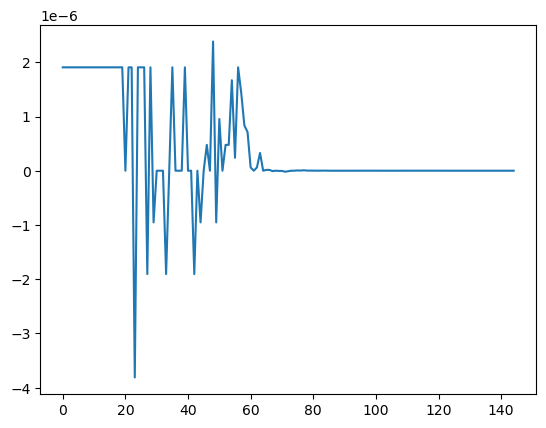

In [756]:
plt.plot(wet_refractivity[:,0,0].astype(np.float32) - hres_model._wet_refractivity[0,0,:])

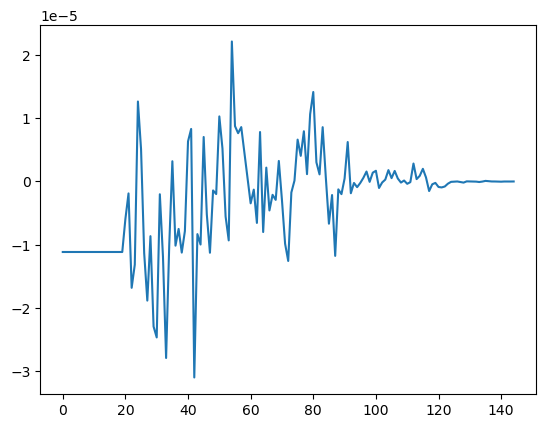

In [757]:
plt.plot(hydrostatic_refractivity[:,0,0] - hres_model._hydrostatic_refractivity[0,0,:])

# Get ZTD

In [ ]:
def _getZTD(self) -> None:
    """
    Compute the full slant tropospheric delay for each weather model grid node, using the reference
    height zref.
    """
    wet = self.getWetRefractivity()
    hydro = self.getHydroRefractivity()

    # Get the integrated ZTD
    wet_total, hydro_total = np.zeros(wet.shape), np.zeros(hydro.shape)
    for level in range(wet.shape[2]):
        wet_total[..., level] = 1e-6 * np.trapz(wet[..., level:], x=self._zs[level:], axis=2)
        hydro_total[..., level] = 1e-6 * np.trapz(hydro[..., level:], x=self._zs[level:], axis=2)
    self._hydrostatic_ztd = hydro_total
    self._wet_ztd = wet_total

In [786]:
def get_ztd(wet_ref:xr.DataArray, hydro_ref:xr.DataArray):
    out_ds = xr.Dataset(data_vars=dict(hydro=hydro_ref,
                                       wet=wet_ref))
    
    #get output
    ztd = xr.zeros_like(out_ds)

    for ilevel in range(ztd.sizes['height']):
        ztd['wet'][ilevel] = 1e-6*np.trapz(out_ds.wet.isel(height=slice(ilevel,None)),
                                            x=out_ds.height[ilevel:],
                                            axis=0)
        ztd['hydro'][ilevel] = 1e-6*np.trapz(out_ds.hydro.isel(height=slice(ilevel,None)),
                                            x=out_ds.height[ilevel:],
                                            axis=0)
    return ztd

In [787]:
ztd =get_ztd(wet_refractivity, hydrostatic_refractivity) 

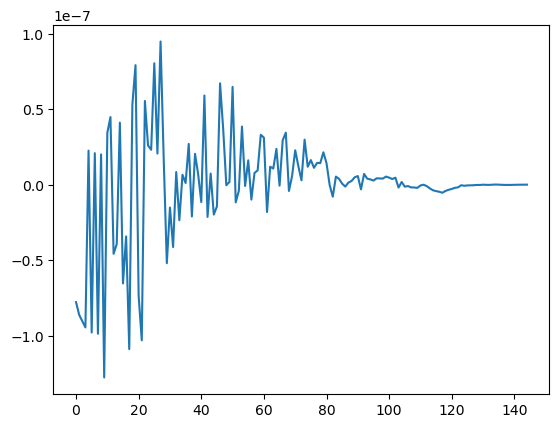

In [791]:
plt.plot(ztd.hydro[:,0,0].astype(np.float32) - hres_model._hydrostatic_ztd[0,0,:])

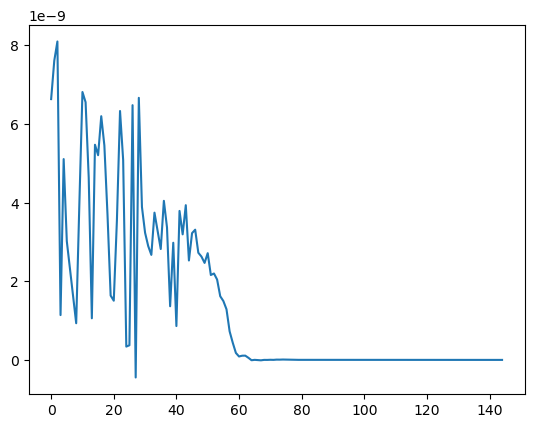

In [792]:
plt.plot(ztd.wet[:,0,0].astype(np.float32) - hres_model._wet_ztd[0,0,:])

# Workflow

In [3]:
R_v = 461.524
k1 = 0.776  # [K/Pa]
k2 = 0.233  # [K/Pa]
k3 = 3.75e3  # [K^2/Pa]
g0 = 9.80665
G1 = 9.80616
Rmax = 6378137
Rmin = 6356752
R_d = 287.06  # in our original code this was 287.053

In [4]:
from RAiDER.interpolate import interpolate_along_axis
from RAiDER.interpolator import fillna3D
from RAiDER.models.model_levels import (A_137_HRES, B_137_HRES, LEVELS_137_HEIGHTS)

In [5]:
# Geoheight to ellipsoidal heights
def get_Re(lats: np.array) -> np.array:
    """
    Returns earth radius as a function of latitude for WGS84.

    Args: lats
        ndarray of geodetic latitudes in degrees

    Returns:
        ndarray of earth radius at each latitude

    Example:
    >>> import numpy as np
    >>> from RAiDER.utilFcns import get_Re
    >>> output = get_Re(np.array([0, 30, 45, 60, 90]))
    >>> output
     array([6378137., 6372770.5219805, 6367417.56705189, 6362078.07851428, 6356752.])
    >>> assert output[0] == 6378137 # (Rmax)
    >>> assert output[-1] == 6356752 # (Rmin)
    """
    return np.sqrt(1 / (((np.cos(np.radians(lats)) ** 2) / Rmax**2) + ((np.sin(np.radians(lats)) ** 2) / Rmin**2)))

def _get_g_ll(lats: np.array) ->  np.array:
    """Compute the variation in gravity constant with latitude."""
    return G1 * (1 - 0.002637 * np.cos(np.radians(2 * lats)) + 0.0000059 * (np.cos(np.radians(2 * lats))) ** 2)

# Partial pressure
def get_svp_xr(t : xr.DataArray):
    t1 = 273.15  # O Celsius
    t2 = 250.15  # -23 Celsius

    tref = t - t1
    wgt = (t - t2) / (t1 - t2)

    tref = t - t1
    wgt = (t - t2) / (t1 - t2)
    svpw = 6.1121 * np.exp((17.502 * tref) / (240.97 + tref))
    svpi = 6.1121 * np.exp((22.587 * tref) / (273.86 + tref))

    svp = svpi + (svpw - svpi) * wgt**2

    svp = svpi + (svpw - svpi) * wgt**2
    ix_bound1 = t > t1
    svp = svp.where(~ix_bound1, svpw)

    ix_bound2 = t < t2
    svp = svp.where(~ix_bound2, svpi)

    return svp * 100

def get_e_from_q(t : xr.DataArray,
                 q : xr.DataArray,
                 p : xr.DataArray):
    # Get standard vapor pressure
    svp = get_svp_xr(t)

    w = q / (1 - q)
    return w * R_v * (p - svp) / R_d

## Surface pressure and geopotential 
def get_surface_pressure(lnsp : xr.DataArray):
    isel = {}
    #Strip time and level dims 
    for i in ['time', 'level']:
        isel[i] = 0 if i in lnsp.dims else None

    lnsp = lnsp.isel(isel)
    lnsp = lnsp.expand_dims(level=range(138))
    lnsp = lnsp.astype(np.float32)

    # Get expanded a and b HRES values
    A_expanded = np.atleast_1d(A_137_HRES)[:, np.newaxis, np.newaxis]
    B_expanded = np.atleast_1d(B_137_HRES)[:, np.newaxis, np.newaxis]

    return  np.float32(A_expanded) + np.float32(B_expanded) * np.exp(lnsp)

def get_geopotential(t : xr.DataArray, 
                     q : xr.DataArray, 
                     z : xr.DataArray, 
                     lnsp : xr.DataArray):
    # Get surface pressure
    Phd = get_surface_pressure(lnsp)

    # Get log and alpha at half levels
    Phd[0] = 1e-10
    dlogP = np.log(Phd).diff(dim="level", label='lower')
    dlogP[0] = np.log(Phd.isel(level=1) / 0.1)
    
    alpha = 1 - (Phd[:-1] / (Phd.diff(dim="level", label='lower'))) * dlogP
    alpha[0] *= np.float32(np.log(2))

    # Reverse
    dlogP = dlogP.isel(level=slice(None, None, -1))
    alpha = alpha.isel(level=slice(None, None, -1))
    dlogP = dlogP.assign_coords(level=range(1,138))
    alpha = alpha.assign_coords(level=range(1,138))

    # compute moist temperature amd reverse
    moist = t * (1 + 0.609133 * q)
    TRd = moist.isel(level=slice(None, None, -1)) * R_d
    TRd = TRd.assign_coords(level=range(1,138))
    z1 = TRd * alpha.astype(np.float64) + z.isel(level=0).expand_dims(level=range(1, 138))
    z2 = TRd * dlogP

    # Get Geopotential, in reverse
    return z1 + z2.astype(np.float64).cumsum('level').shift(level=1, fill_value=0)

In [233]:
def ztd_xr(da : xr.Dataset):
    # Get surface pressure and geopotential
    p = get_surface_pressure(da.lnsp)[:-1]
    da['p'] = p.assign_coords(level=range(1,138)).expand_dims('time')

    # Geoheights
    ght = get_geopotential(da.t, da.q,
                           da.z, da.lnsp).astype(np.float32) / g0
    # Ellipsoidal height
    g_ll = _get_g_ll(da.latitude)  # gravity function of latitude
    Re = get_Re(da.latitude)  # Earth radius function of latitude
    hgt = (ght * Re) / (g_ll / g0 * Re - ght)

    # Partial pressure
    da['e'] = get_e_from_q(da.t, da.q, da.p)
    # drop unenssessary
    da = da.drop_vars(['z', 'lnsp', 'q'])

    # Uniform heights
    t_interp = uniform_heights(da.t, hgt, np.flipud(LEVELS_137_HEIGHTS), 1e16)
    e_interp = uniform_heights(da.e, hgt, np.flipud(LEVELS_137_HEIGHTS), 0)
    p_interp= uniform_heights(da.p, hgt, np.flipud(LEVELS_137_HEIGHTS), 0)
    
    # Get refractivity
    wet_refractivity = k2 * e_interp / t_interp + k3 * e_interp / t_interp**2
    hydrostatic_refractivity = k1 * p_interp / t_interp

    # Get ztd
    ztd =get_ztd(wet_refractivity, hydrostatic_refractivity) 
    return ztd

# Uniform heights
def uniform_heights(ds : xr.DataArray, hgt: xr.DataArray, 
                    new_heights : list, fill_value:float=0):
    # new heights
    ds= ds.copy()
    new_shape = (ds.sizes['latitude'], ds.sizes['longitude'], 1) 
    new_zs = np.tile(new_heights, new_shape)

    # Interpolate
    ds = ds.transpose('time', 'latitude', 'longitude', 'level')
    hgt = hgt.transpose('time', 'latitude', 'longitude', 'level')
    isel_slice = dict(time=0)
    interp = interpolate_along_axis(hgt.isel(isel_slice),
                                    ds.isel(isel_slice)[:,:,::-1],
                                    new_zs,  axis=2, 
                                    fill_value=np.nan)
    # fill nans
    inter_filled = fillna3D(interp, fill_value=fill_value)

    return xr.DataArray(inter_filled.transpose(2,0,1),
                        dims=['height', 'latitude', 'longitude'],
                        coords={'height':new_heights,
                              'latitude':ds.latitude,
                              'longitude':ds.longitude})

def cumulative_trapz_vectorized(data):
    """
    Perform cumulative trapezoidal integration efficiently using vectorized operations.

    Parameters:
        data (np.ndarray): Data values to integrate, shape (height, lat, lon).
        height (np.ndarray): Height levels, shape (height,).

    Returns:
        np.ndarray: Integrated values at each height level.
    """
    # Get output datarray
    out_xr = xr.zeros_like(data)
    # Compute differential heights (shape: (height-1,))
    dh = np.diff(data.height)

    # Ensure broadcasting: Reshape `dh` to (height-1, 1, 1) to match (height, lat, lon)
    dh = dh[:, np.newaxis, np.newaxis]

    # Compute trapezoidal integration elements: (height-1, lat, lon)
    trapz_values = 0.5 * (data[:-1].data + data[1:].data) * dh

    # Compute cumulative integral from top to bottom (reverse order)
    out_xr[:-1] = 1e-6 * np.cumsum(trapz_values[::-1], axis=0)[::-1]

    return out_xr


# Get ztd
def get_ztd(wet_ref:xr.DataArray, hydro_ref:xr.DataArray):
    hydro = cumulative_trapz_vectorized(hydro_ref)
    wet = cumulative_trapz_vectorized(wet_ref)
    return xr.Dataset(data_vars={'hydro': hydro,
                                 'wet': wet,
                                 'hydro_ref':hydro_ref,
                                 'wet_ref':wet_ref})

In [212]:
%%time
get_ztd(cc.wet_ref, cc.hydr_ref)

CPU times: user 206 ms, sys: 278 ms, total: 484 ms
Wall time: 482 ms


<xarray.Dataset> Size: 140MB
Dimensions:    (height: 145, latitude: 213, longitude: 284)
Coordinates:
  * height     (height) float64 1kB -500.0 -300.0 -200.0 ... 7.458e+04 8.03e+04
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * longitude  (longitude) float32 1kB 65.04 65.11 65.18 ... 84.8 84.87 84.94
Data variables:
    hydro      (height, latitude, longitude) float64 70MB 2.394 2.392 ... 0.0
    wet        (height, latitude, longitude) float64 70MB 0.1014 0.1008 ... 0.0

In [811]:
from dask.distributed import Client

In [817]:
client.close()

In [819]:
client = Client(n_workers=4, threads_per_worker=2)

/u/aurora-r0/govorcin/miniconda/miniforge/envs/opera_tropo/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39377 instead
  warnings.warn(


In [820]:
client.dashboard_link

'http://127.0.0.1:39377/status'

In [234]:
%%time
cc = ztd_xr(ds1)

CPU times: user 6.95 s, sys: 1.45 s, total: 8.4 s
Wall time: 7.8 s


In [235]:
cc

<xarray.Dataset> Size: 281MB
Dimensions:    (height: 145, latitude: 213, longitude: 284)
Coordinates:
  * height     (height) float64 1kB -500.0 -300.0 -200.0 ... 7.458e+04 8.03e+04
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * longitude  (longitude) float32 1kB 65.04 65.11 65.18 ... 84.8 84.87 84.94
Data variables:
    hydro      (height, latitude, longitude) float64 70MB 2.394 2.392 ... 0.0
    wet        (height, latitude, longitude) float64 70MB 0.1014 0.1008 ... 0.0
    hydro_ref  (height, latitude, longitude) float64 70MB 254.9 253.4 ... 0.0
    wet_ref    (height, latitude, longitude) float64 70MB 23.92 23.31 ... 0.0

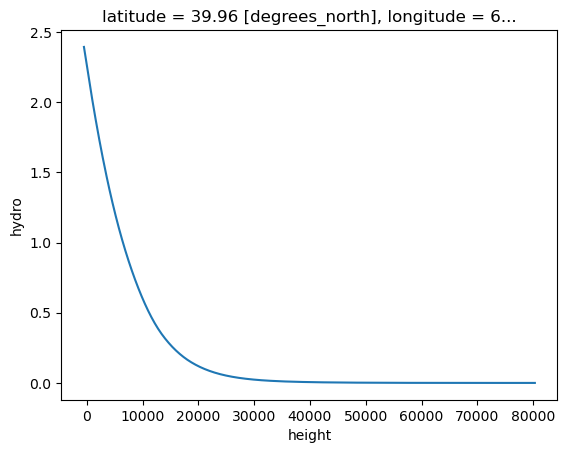

In [214]:
cc.hydro[:,0,0].plot()

In [215]:
%%time
from opera_tropo.core import calculate_ztd
cc1 = calculate_ztd(ds1)

CPU times: user 10.4 s, sys: 5.67 s, total: 16 s
Wall time: 15.6 s


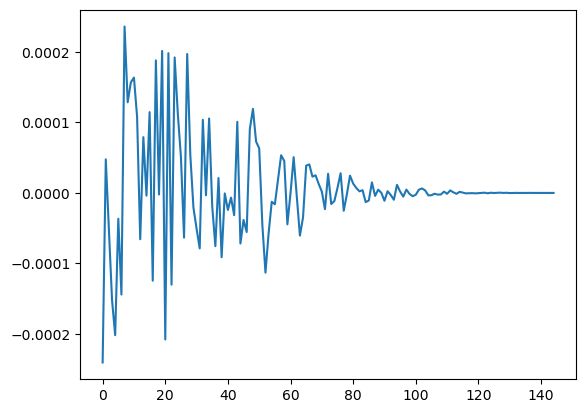

In [222]:
plt.plot(cc.hydro[:,0,0] - cc1.hydrostatic_delay[0,:,0,0])

In [223]:
# Step 1
def step1(da:xr.Dataset):
    p = get_surface_pressure(da.lnsp)[:-1]
    da['p'] = p.assign_coords(level=range(1,138)).expand_dims('time')

    # Geoheights
    ght = get_geopotential(da.t, da.q,
                           da.z, da.lnsp).astype(np.float32) / g0
    # Ellipsoidal height
    g_ll = _get_g_ll(da.latitude)  # gravity function of latitude
    Re = get_Re(da.latitude)  # Earth radius function of latitude
    hgt =  ((ght * Re) / (g_ll / g0 * Re - ght))
    da['hgt'] = hgt.isel(level=slice(None,None,-1)).assign_coords(level=range(1,138))

    # Partial pressure
    da['e'] = get_e_from_q(da.t, da.q, da.p)
    # drop unenssessary
    da = da.drop_vars(['z', 'lnsp', 'q'])
    return da

def step2(da: xr.Dataset):
    hgt = da.hgt.isel(level=slice(None, None, -1))
    t_interp = uniform_heights(da.t, hgt, np.flipud(LEVELS_137_HEIGHTS), 1e16)
    e_interp = uniform_heights(da.e, hgt, np.flipud(LEVELS_137_HEIGHTS), 0)
    p_interp= uniform_heights(da.p, hgt, np.flipud(LEVELS_137_HEIGHTS), 0)
    return xr.Dataset(data_vars=dict(t = t_interp, e=e_interp, p=p_interp))

def step3(da: xr.Dataset):
    # Get refractivity
    wet_refractivity = (k2 * da.e / da.t) + (k3 * da.e / da.t**2)
    hydrostatic_refractivity = (k1 * da.p / da.p)

    # Get ztd
    ztd = get_ztd(wet_refractivity, hydrostatic_refractivity) 
    return ztd


In [224]:
%%time
d = step1(ds1)

CPU times: user 401 ms, sys: 456 ms, total: 857 ms
Wall time: 858 ms


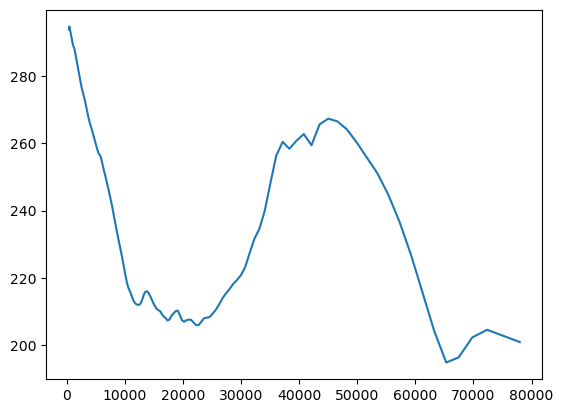

In [225]:
plt.plot(d.isel(time=0, latitude=0, longitude=0).hgt, d.isel(time=0, latitude=0, longitude=0).t)

In [226]:
%%time
d = step2(d).compute()

CPU times: user 6.32 s, sys: 503 ms, total: 6.82 s
Wall time: 6.28 s


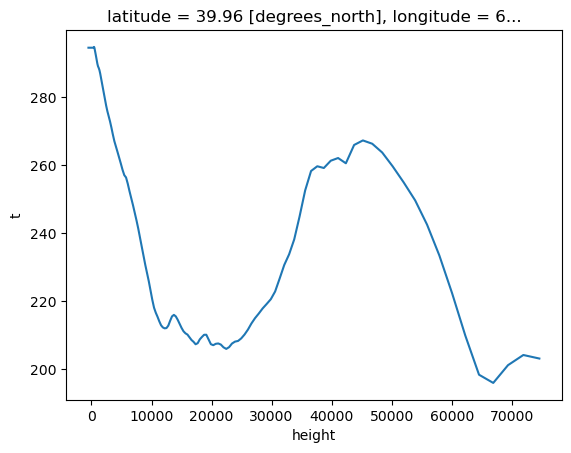

In [227]:
d.t[:-1, 0,0].plot()

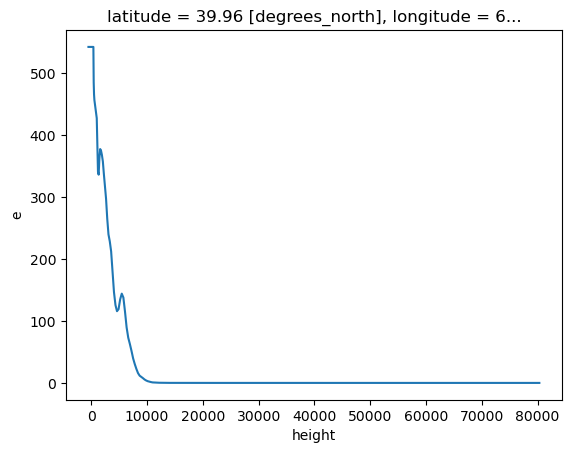

In [228]:
d.e[:,0,0].plot()

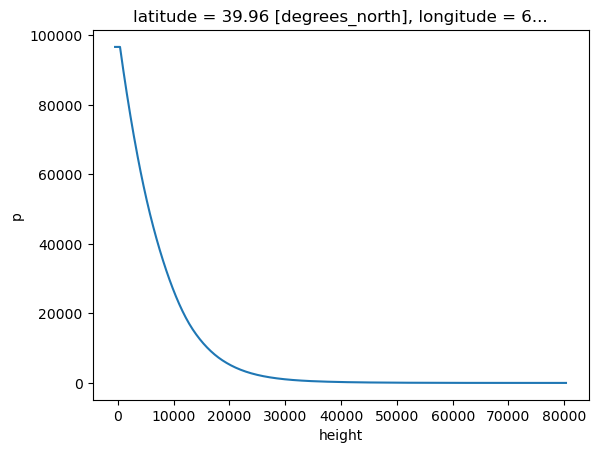

In [229]:
d.p[:,0,0].plot()

In [231]:
%%time
step3(d)

CPU times: user 226 ms, sys: 463 ms, total: 689 ms
Wall time: 687 ms


<xarray.Dataset> Size: 140MB
Dimensions:    (height: 145, latitude: 213, longitude: 284)
Coordinates:
  * height     (height) float64 1kB -500.0 -300.0 -200.0 ... 7.458e+04 8.03e+04
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * longitude  (longitude) float32 1kB 65.04 65.11 65.18 ... 84.8 84.87 84.94
Data variables:
    hydro      (height, latitude, longitude) float64 70MB nan nan ... 0.0 0.0
    wet        (height, latitude, longitude) float64 70MB 0.1014 0.1008 ... 0.0

In [911]:
%%time
step3(step2(step1(ds1)))

CPU times: user 12.2 s, sys: 7.96 s, total: 20.2 s
Wall time: 18.9 s


<xarray.Dataset> Size: 140MB
Dimensions:    (height: 145, latitude: 213, longitude: 284)
Coordinates:
  * height     (height) float64 1kB -500.0 -300.0 -200.0 ... 7.458e+04 8.03e+04
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * longitude  (longitude) float32 1kB 65.04 65.11 65.18 ... 84.8 84.87 84.94
Data variables:
    hydro      (height, latitude, longitude) float64 70MB nan nan ... 0.0 0.0
    wet        (height, latitude, longitude) float64 70MB 0.1014 0.1008 ... 0.0